In [1]:
%autosave 0
import numpy as np
import pandas as pd

from sklearn.linear_model import ElasticNet
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px

from datetime import date, timedelta
from joblib import dump

from source_code.SqlCo import Sqldd

import warnings
warnings.filterwarnings("ignore") 

Autosave disabled
Local Sec Env loaded


Start Day : 28/03

Trying to predict number of new cases & deaths one day before

Working with data update everyday here : https://ourworldindata.org/coronavirus-source-data
I take the full dataset linked

In [2]:
## you can dl csv data with link and replace this code for pd.red_csv()
tip = Sqldd()
cnx, cursor = tip.get_bdd_co()

In [3]:
%%time
df = pd.read_sql(f"SELECT * FROM cov_baseline;", con=cnx) 

In [9]:
def get_view():
    df = pd.read_sql(f"SELECT date,location FROM cov_baseline;", con=cnx)
    df_p = pd.read_sql(f"SELECT * FROM cov_aipred;", con=cnx)
    df_r = pd.read_sql(f"SELECT * FROM cov_rapport;", con=cnx)

    df1 = pd.merge(df_p,df_r, left_on=['date','country'], right_on=['date','country'],
                   suffixes=('_left', '_right'))
    df_new = pd.merge(df,df1, left_on=['date','location'], right_on=['date','country'],
                      suffixes=('_left', '_right'), how = 'outer')
    return df_new

In [11]:
df.columns

Index(['id', 'iso_code', 'continent', 'location', 'date', 'total_cases',
       'new_cases', 'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers',
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand',
       'life_expectancy', 'human_development_index'],
      dtype='object')

In [10]:
df.head(3)

,id,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,1,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,0.0,...,1803.99,0.0,597.029,9.59,0.0,0.0,37.746,0.5,64.83,0.498
1,2,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,0.0,...,1803.99,0.0,597.029,9.59,0.0,0.0,37.746,0.5,64.83,0.498
2,3,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,0.0,...,1803.99,0.0,597.029,9.59,0.0,0.0,37.746,0.5,64.83,0.498


In [7]:
df.tail(3)

,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths
74149,Yemen,2021-02-12,2136.0,2.0,1.714,616.0,0.0
74150,Zambia,2021-02-12,67681.0,1083.0,1036.290,931.0,17.0
74151,Zimbabwe,2021-02-12,35045.0,181.0,102.000,1393.0,29.0


In [8]:
df['location'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Anguilla', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin',
       'Bermuda', 'Bhutan', 'Bolivia', 'Bonaire Sint Eustatius and Saba',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'British Virgin Islands', 'Brunei', 'Bulgaria', 'Burkina Faso',
       'Burundi', 'Cambodia', 'Cameroon', 'Canada', 'Cape Verde',
       'Cayman Islands', 'Central African Republic', 'Chad', 'Chile',
       'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus',
       'Czech Republic', 'Democratic Republic of Congo', 'Denmark',
       'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Ethiopia', 'Faeroe Islands', 'Falkland Isla

# Data Exploration

In [6]:
def massBalance(subject,df,country):
    """ Plot evolution of data by columns
    params :
        subject = name of cols concerned by the plot
        df = The Dataframe
        country = Name of location isolated for the plot
    """
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.line(x=df["date"], y=df[f"{subject}"])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [7]:
## Plotly graph will be not display on Git ##
# massBalance("total_deaths",df,"World")
# massBalance("total_deaths",df,"France")
# massBalance("total_deaths",df,"China")
# massBalance("total_deaths",df,"Italy")
# massBalance("total_deaths",df,"Spain")
# massBalance("total_deaths",df,"United States")
# massBalance("total_deaths",df,"Germany")
# massBalance("total_deaths",df,"Iran")
# massBalance("total_deaths",df,"Turkey")
# massBalance("total_deaths",df,"Brazil")

In [8]:
## Plotly graph will be not display on Git ##
# massBalance("total_cases",df,"World")
# massBalance("total_cases",df,"France")
# massBalance("total_cases",df,"China")
# massBalance("total_cases",df,"Italy")
# massBalance("total_cases",df,"Spain")
# massBalance("total_cases",df,"United States")
# massBalance("total_cases",df,"United Kingdom")
# massBalance("total_cases",df,"Germany")
# massBalance("total_cases",df,"Iran")
# massBalance("total_cases",df,"Turkey")
# massBalance("total_cases",df,"Brazil")

In [9]:
def newOverTime(subject,df,country):
    df = df[df['location'].isin([f"{country}"])]
    df = df.iloc[::-1]
    thisPlot = px.bar(df, x=df["date"], y=df[f'{subject}'])
    thisPlot.update_layout(title=f"Covid {subject} {country}",
                           xaxis_title="Day",
                           yaxis_title="Volume",
                           font=dict(family="Courier New, monospace",size=18, color="#78281F"))
    thisPlot.show()

In [10]:
## Plotly graph will be not display on Git ##
# newOverTime("new_cases",df,"World")
# newOverTime("new_cases",df,"France")
# newOverTime("new_cases",df,"China")
# newOverTime("new_cases",df,"Italy")
# newOverTime("new_cases",df,"Spain")
# newOverTime("new_cases",df,"United States")
# newOverTime("new_cases",df,"United Kingdom")
# newOverTime("new_cases",df,"Germany")
# newOverTime("new_cases",df,"Iran")
# newOverTime("new_cases",df,"Turkey")
# newOverTime("new_cases",df,"Brazil")

In [11]:
## Plotly graph will be not display on Git ##
# newOverTime("new_deaths",df,"World")
# newOverTime("new_deaths",df,"France")
# newOverTime("new_deaths",df,"China")
# newOverTime("new_deaths",df,"Italy")
# newOverTime("new_deaths",df,"Spain")
# newOverTime("new_deaths",df,"United States")
# newOverTime("new_deaths",df,"United Kingdom")
# newOverTime("new_deaths",df,"Germany")
# newOverTime("new_deaths",df,"Iran")
# newOverTime("new_deaths",df,"Turkey")
# newOverTime("new_deaths",df,"Brazil")

In [12]:
def worldrep(subject,graph_long=5,val_larg=1000000,df=df):
    fidf_mod = df.sort_values(subject, axis=0, ascending =False).head(500)
    f, ax = plt.subplots(figsize=(15, graph_long))

    ax.set(xlim=(0, val_larg), 
           ylabel= "Pays",
           xlabel= subject,
           Title= (f"{subject} by country")
          )
    ax.legend()
    sns.despine(top=True)
    ax = sns.barplot(x=fidf_mod[subject], y=fidf_mod["location"])


No handles with labels found to put in legend.


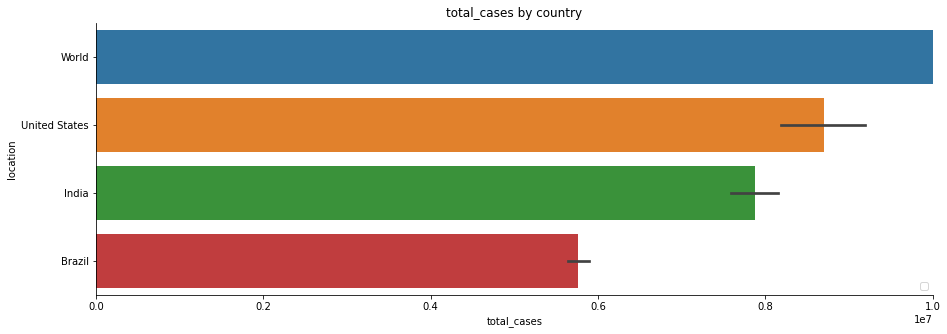

In [13]:
worldrep("total_cases",graph_long=5,val_larg=10000000)

No handles with labels found to put in legend.


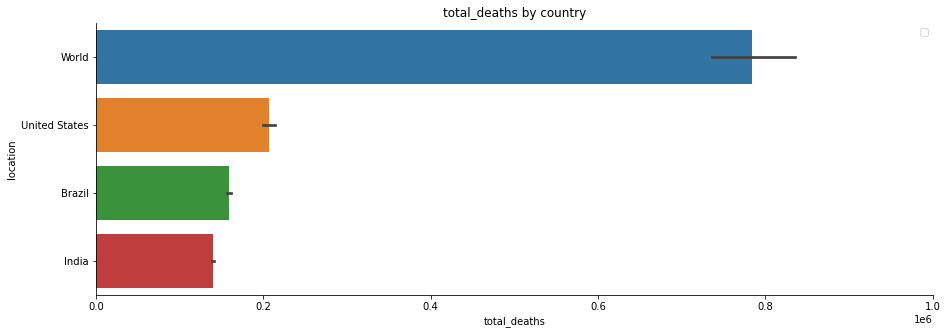

In [14]:
worldrep("total_deaths",val_larg=1000000)

In [15]:
dds = df[df["date"].isin([f'{date.today() - timedelta(days=1)}'])]

No handles with labels found to put in legend.


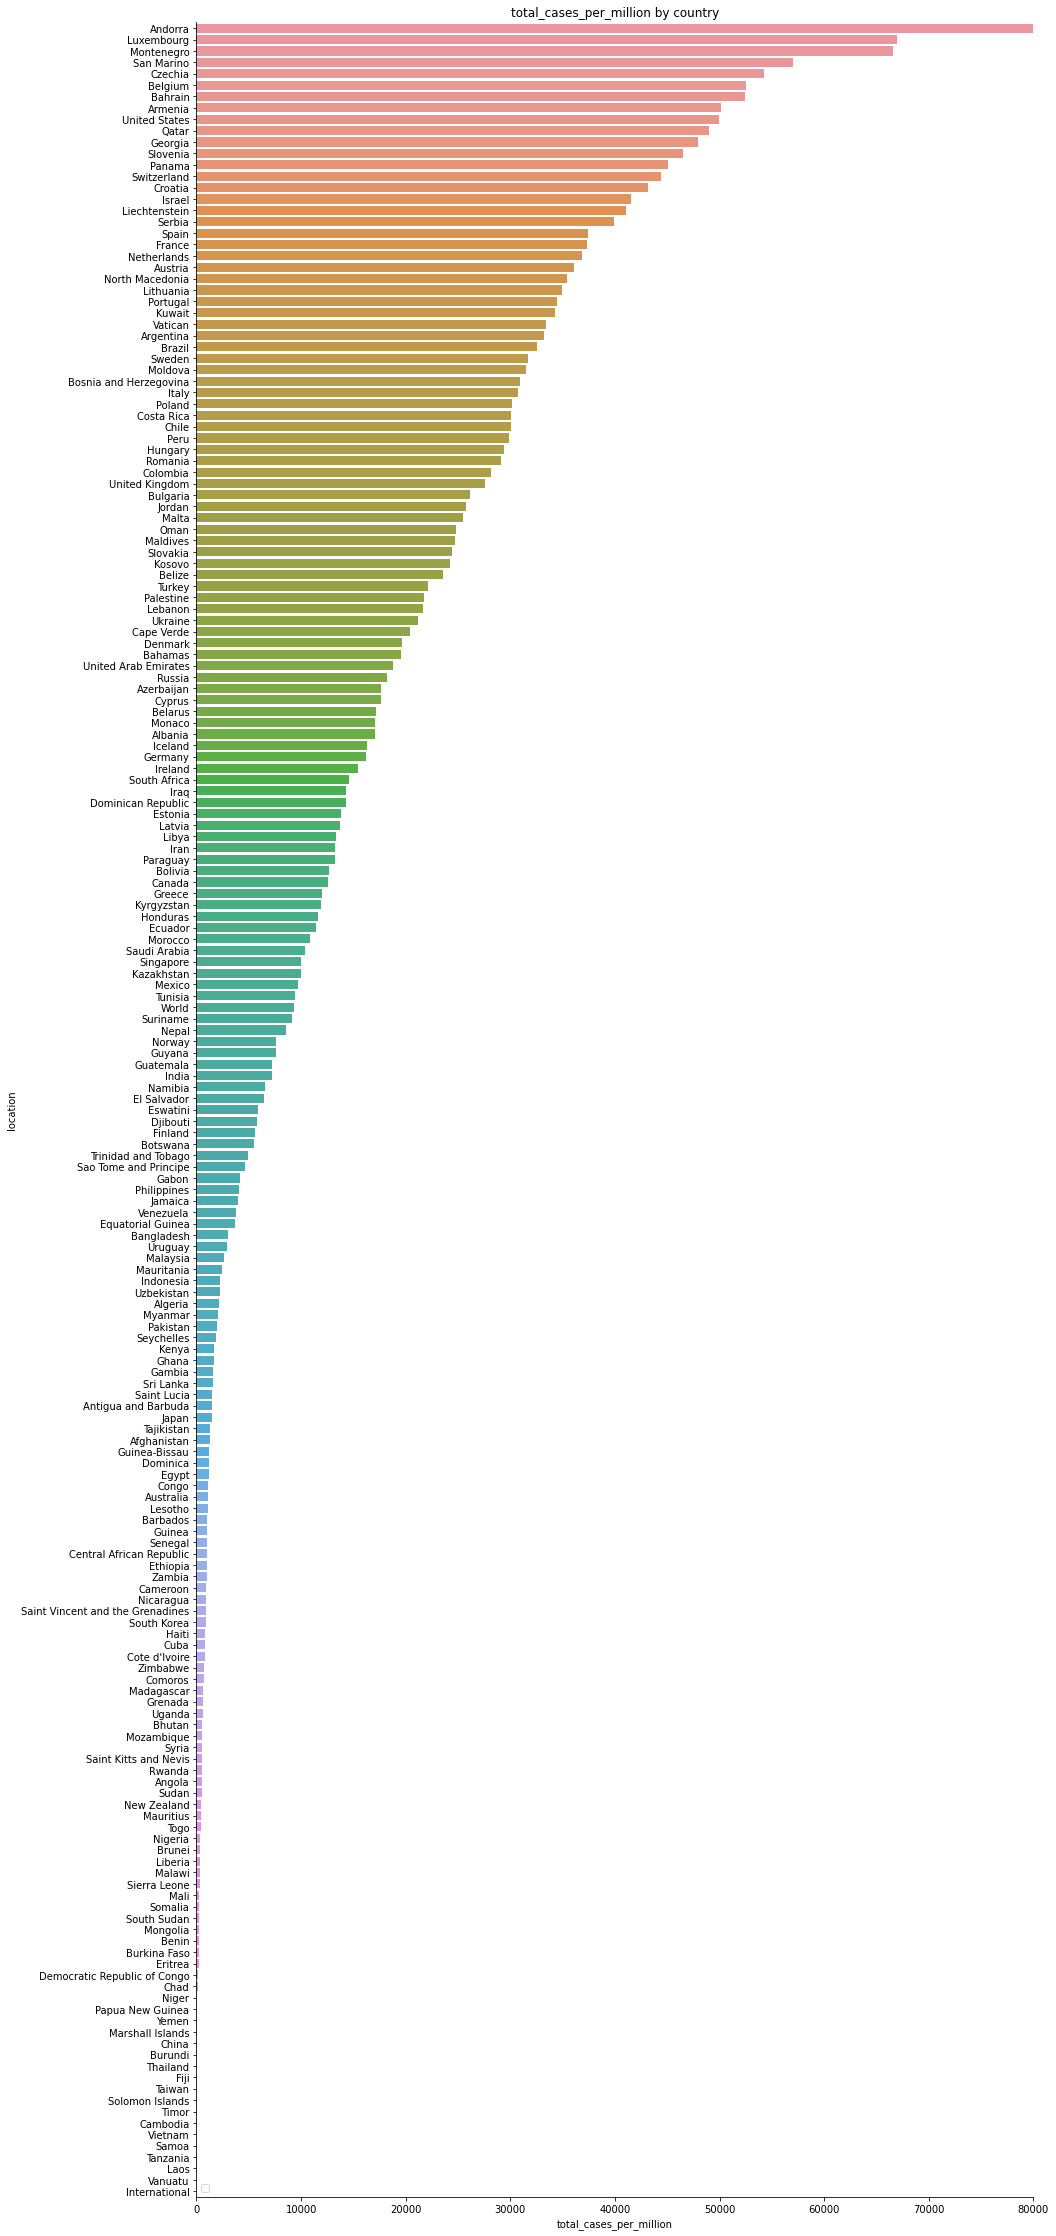

In [16]:
try:
    worldrep("total_cases_per_million",graph_long=40,val_larg=80000,df=dds)
except:
    print("Not today")

No handles with labels found to put in legend.


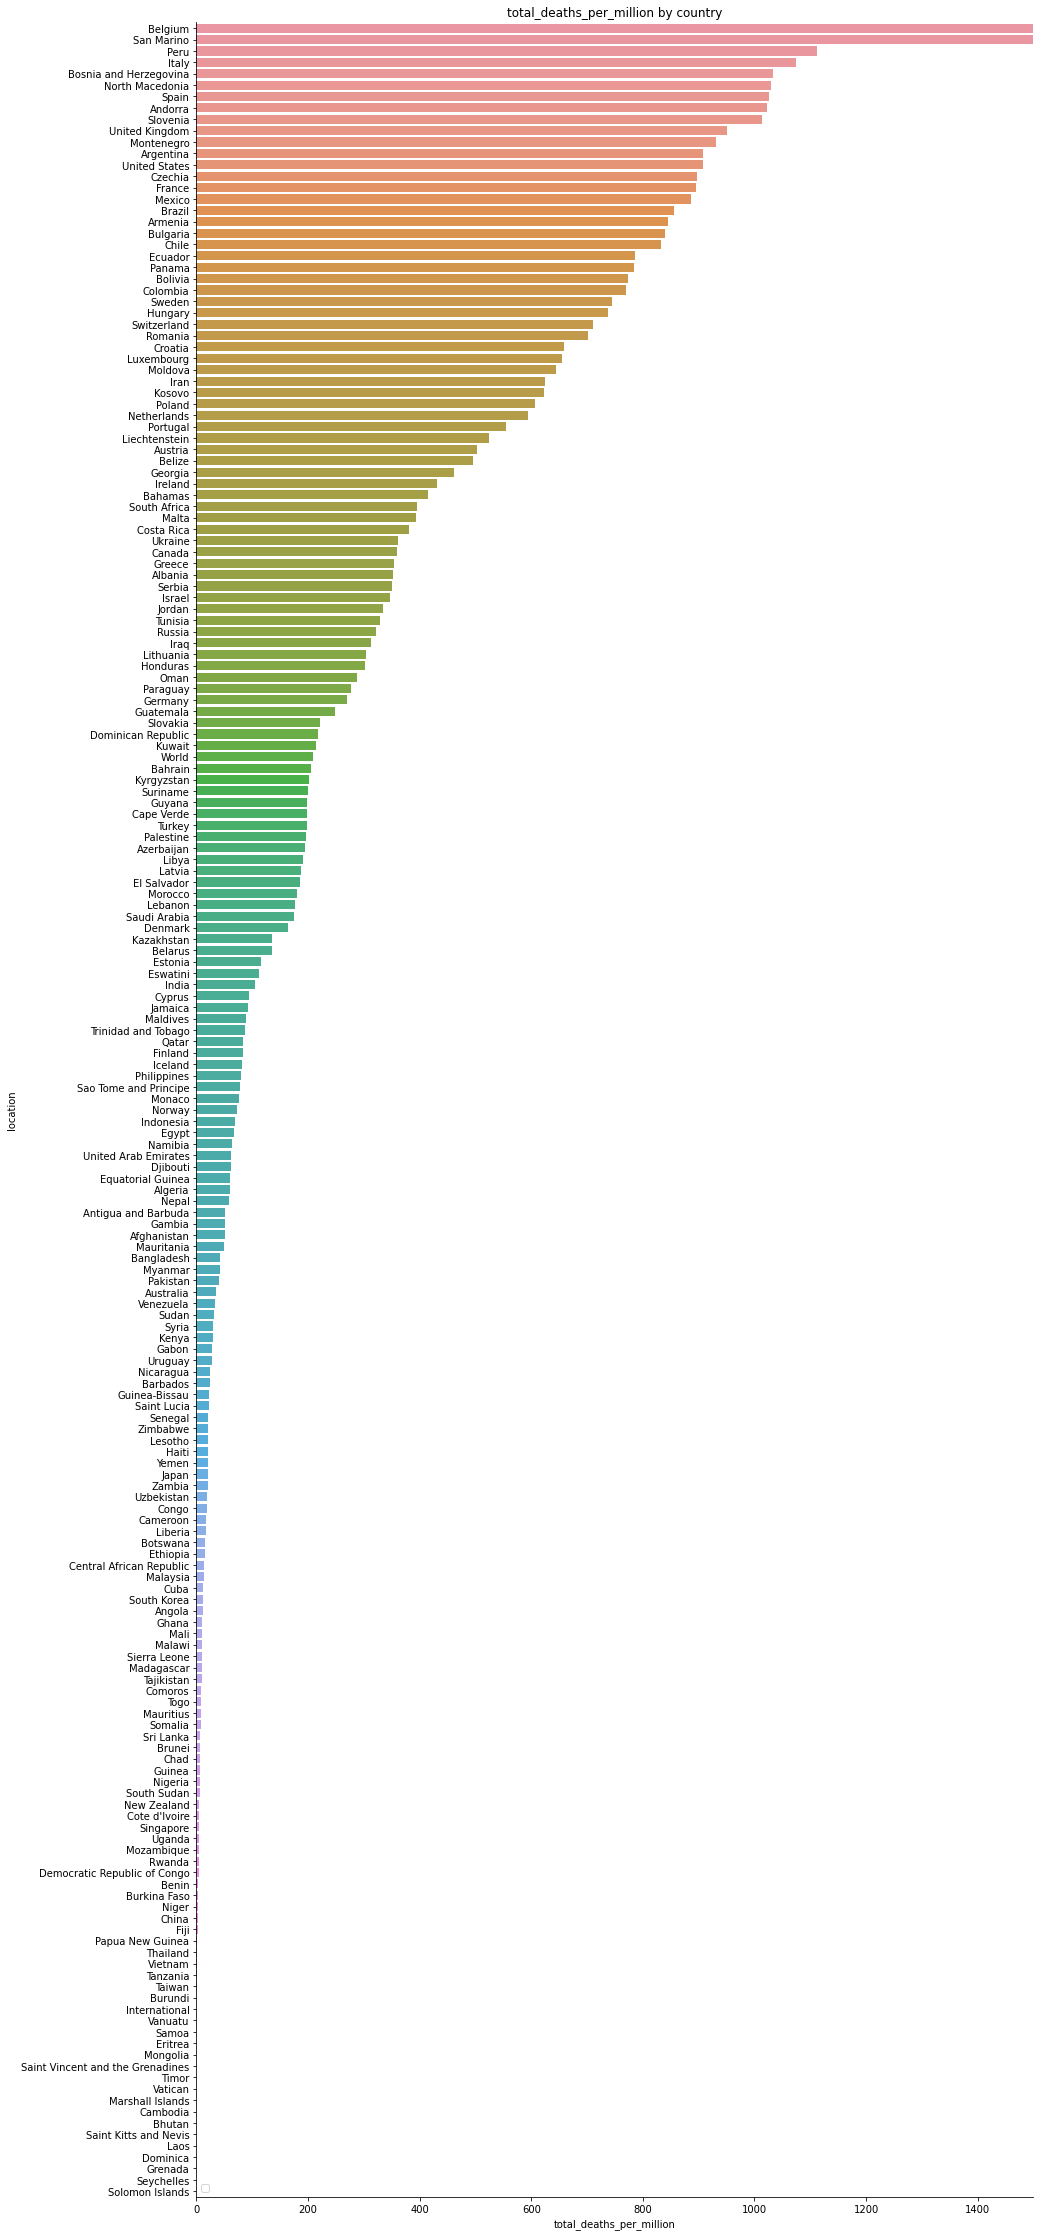

In [17]:
try :
    worldrep("total_deaths_per_million",graph_long=40,val_larg=1500,df=dds)
    is_full_data = True
except:
    is_full_data = False
    print("not today")

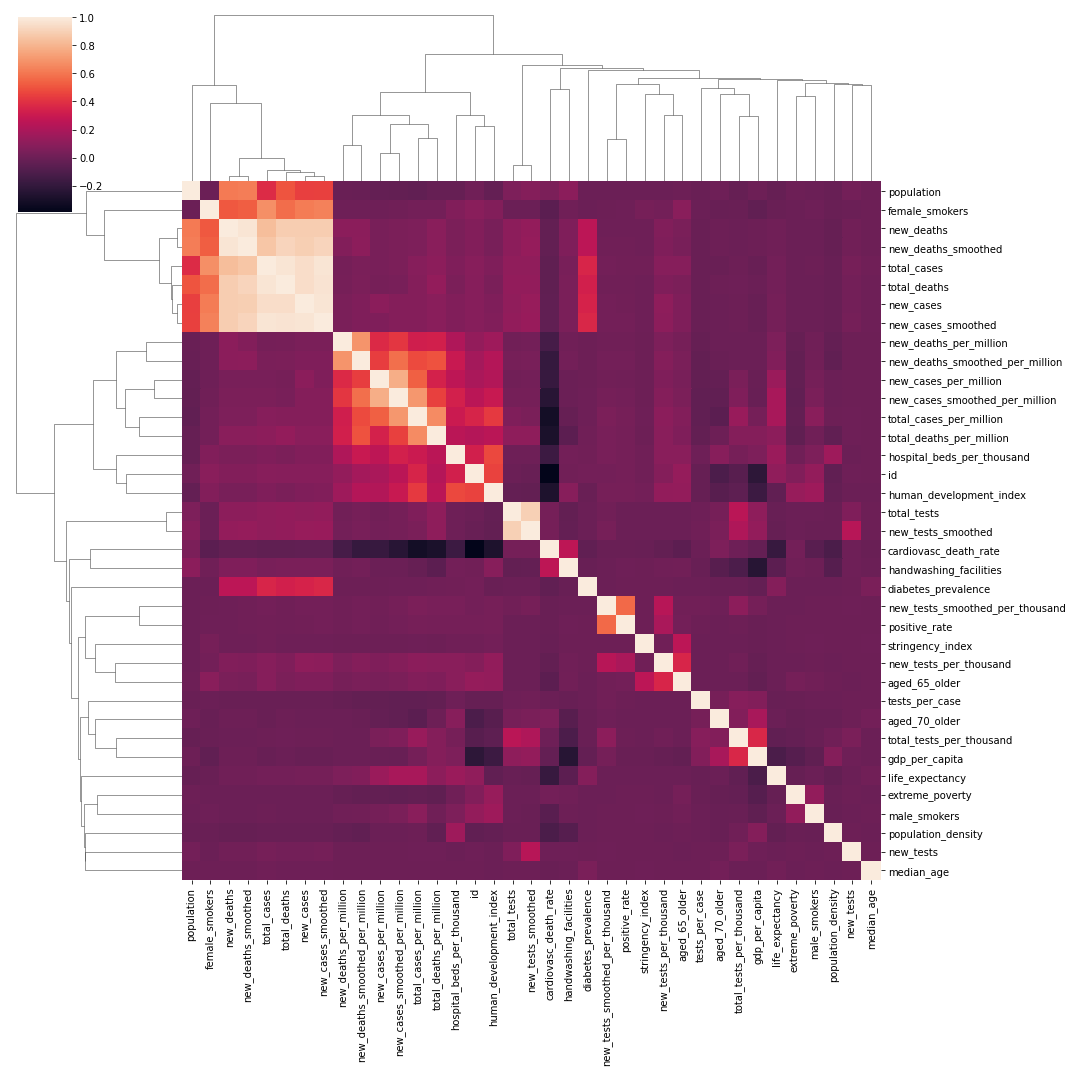

In [18]:
if is_full_data:
    corr = df.corr()
    sns.clustermap(corr,figsize=(15, 15))
else :
    print("not today")

# Modeling routines

In [19]:
def createModel(df,subject,periode,country,n_splits=3,max_iter=5000):

    df = df[df['location'].isin([f"{country}"])] 
    vals = df[[f"{subject}"]].values
    
    imp = SimpleImputer(missing_values=np.nan, strategy='constant')
    vals = imp.fit_transform(vals)
    
    hisShape = vals.shape[0]
    x_train = []
    y_train = []

    for i in range(periode,hisShape):
        x_train.append(vals[(i-periode):i,0]) 
        y_train.append(vals[i,0])

    x_train = np.array(x_train) 
    y_train = np.array(y_train)
    
    ###############################################################
    model = ElasticNet(random_state=0,max_iter=max_iter) 
    # tol=0.01 by reducing this hp warning disapear, pred will be highter 
    ###############################################################
    
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = cross_val_score(model, x_train, y_train, cv=tscv)
    print(f"R^2: {scores.mean()} (+/- {scores.std()})")
    
    model.fit(x_train,y_train)
    print("Coef : ",model.coef_)
    
    return vals, x_train,y_train, model

In [20]:
def predicTomorow(vals,model,periode):
    tmw = vals[-periode:]
    lili = []
    for i in tmw:
        lili.append(int(i))
    lili = np.array(lili).reshape(1, -1) 
    res = int(model.predict(lili))
    last_day = lili[0][periode-1]
    diff_betw = res-last_day
    print(f"{periode} Last_days : ",lili)
    print("Today : ",last_day)
    print("Prediction + : ",diff_betw)
    print("Tomorow : ",res)
    return last_day, res

In [21]:
def conbine(df,subject,periode,country):
    vals, x_train, y_train, model = createModel(df,subject,periode,country)
    last_day, ress = predicTomorow(vals,model,periode)
    return last_day, ress

In [22]:
def fullRoutines(df,periode,country):
    print(f"********* For {country} **************")
    print("                                     ")
    print("--------- Total Cases -----------------")
    print("                                     ")
    last_day_cases, res1 = conbine(df,"total_cases",periode,f"{country}")
    print("                                     ")
    print("--------- Total Death -----------------")
    print("                                     ")
    last_day_death, res2 = conbine(df,"total_deaths",periode,f"{country}")
    print("                                     ")
    return last_day_cases, last_day_death, res1, res2

# Prediction Tomorow

In [23]:
periode = 3

In [24]:
last_day_cases, last_day_death, res1ww, res2ww = fullRoutines(df,periode,"World")
world_data = last_day_cases, last_day_death, res1ww, res2ww

********* For World **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9995132038942028 (+/- 0.0003750789437909716)
Coef :  [1.02975526e+00 3.46634776e-05 3.51516210e-05]
3 Last_days :  [[71704900 72252500 72849600]]
Today :  72849600
Prediction + :  1101931
Tomorow :  73951531
                                     
--------- Total Death -----------------
                                     
R^2: 0.9997136260826366 (+/- 6.444893380826436e-05)
Coef :  [1.01556957e+00 8.57779279e-05 9.06281910e-05]
3 Last_days :  [[1604980 1612360 1621150]]
Today :  1621150
Prediction + :  14546
Tomorow :  1635696
                                     


In [25]:
last_day_casesfr, last_day_deathfr, res1fr, res2fr = fullRoutines(df,periode,"France")
french_data = last_day_casesfr, last_day_deathfr, res1fr, res2fr

********* For France **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9933788269273021 (+/- 0.008518817790695899)
Coef :  [-0.6529201   0.74376738  0.91426161]
3 Last_days :  [[2405260 2430610 2433860]]
Today :  2433860
Prediction + :  29588
Tomorow :  2463448
                                     
--------- Total Death -----------------
                                     
R^2: 0.9931596945128716 (+/- 0.005785378730030582)
Coef :  [-0.65702476  0.72124526  0.93696302]
3 Last_days :  [[57671 58015 58391]]
Today :  58391
Prediction + :  313
Tomorow :  58704
                                     


In [26]:
last_day_casesch, last_day_deathch, res1ch, res2ch = fullRoutines(df,periode,"China")
china_data = last_day_casesch, last_day_deathch, res1ch, res2ch

********* For China **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9624932097929318 (+/- 0.031937691832077376)
Coef :  [-0.34002     0.01140521  1.32292552]
3 Last_days :  [[94217 94328 94427]]
Today :  94427
Prediction + :  61
Tomorow :  94488
                                     
--------- Total Death -----------------
                                     
R^2: 0.09658742154382945 (+/- 1.1394692484896503)
Coef :  [-0.07911812  0.01256825  1.05778655]
3 Last_days :  [[4749 4751 4754]]
Today :  4754
Prediction + :  3
Tomorow :  4757
                                     


In [27]:
last_day_casesit, last_day_deathit, res1it, res2it = fullRoutines(df,periode,"Italy")
italy_data = last_day_casesit, last_day_deathit, res1it, res2it

********* For Italy **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.992587785940405 (+/- 0.010182871529411268)
Coef :  [-0.84829793  0.90880388  0.94283663]
3 Last_days :  [[1825780 1843710 1855740]]
Today :  1855740
Prediction + :  20792
Tomorow :  1876532
                                     
--------- Total Death -----------------
                                     
R^2: 0.9941605987016296 (+/- 0.006954478831192969)
Coef :  [-0.83627769  0.90342718  0.93340836]
3 Last_days :  [[64036 64520 65011]]
Today :  65011
Prediction + :  438
Tomorow :  65449
                                     


In [28]:
# last_day_casessp, last_day_deathsp, res1sp, res2sp = fullRoutines(df,periode,"Belgium")
# spain_data = last_day_casessp, last_day_deathsp, res1sp, res2sp

In [29]:
last_day_casesus, last_day_deathus, res1us, res2us = fullRoutines(df,periode,"United States")
usa_data = last_day_casesus, last_day_deathus, res1us, res2us

********* For United States **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9917560913991094 (+/- 0.010911999190572166)
Coef :  [0.30767997 0.36168376 0.35336615]
3 Last_days :  [[16062300 16253200 16519500]]
Today :  16519500
Prediction + :  141543
Tomorow :  16661043
                                     
--------- Total Death -----------------
                                     
R^2: 0.718895493868863 (+/- 0.39671766593826285)
Coef :  [0.01099614 0.47677783 0.51729599]
3 Last_days :  [[297779 299168 300479]]
Today :  300479
Prediction + :  1575
Tomorow :  302054
                                     


In [30]:
last_day_casesuk, last_day_deathuk, res1uk, res2uk = fullRoutines(df,periode,"United Kingdom")
uk_data = last_day_casesuk, last_day_deathuk, res1uk, res2uk

********* For United Kingdom **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9847020608386141 (+/- 0.021237631975721396)
Coef :  [-0.36082158  0.67772106  0.69644547]
3 Last_days :  [[1835950 1854490 1874870]]
Today :  1874870
Prediction + :  25337
Tomorow :  1900207
                                     
--------- Total Death -----------------
                                     
R^2: 0.8343508100462674 (+/- 0.21483045396641823)
Coef :  [-0.72029054  0.80806588  0.91241055]
3 Last_days :  [[64123 64267 64500]]
Today :  64500
Prediction + :  158
Tomorow :  64658
                                     


In [31]:
last_day_casesger, last_day_deathger, res1ger, res2ger = fullRoutines(df,periode,"Germany")
ger_data = last_day_casesger, last_day_deathger, res1ger, res2ger

********* For Germany **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.986955061395677 (+/- 0.01786306665400032)
Coef :  [-0.53592133  0.67835347  0.86928867]
3 Last_days :  [[1336100 1350810 1357260]]
Today :  1357260
Prediction + :  22324
Tomorow :  1379584
                                     
--------- Total Death -----------------
                                     
R^2: 0.7608033354676184 (+/- 0.3321339584770723)
Coef :  [-0.80338592  0.8308248   0.97497068]
3 Last_days :  [[21900 22106 22634]]
Today :  22634
Prediction + :  205
Tomorow :  22839
                                     


In [32]:
last_day_casesIran, last_day_deathIran, res1Iran, res2Iran = fullRoutines(df,periode,"Iran")
Iran_data = last_day_casesIran, last_day_deathIran, res1Iran, res2Iran

********* For Iran **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9985336499713989 (+/- 0.0005487493764846575)
Coef :  [0.2198733  0.40808962 0.39353172]
3 Last_days :  [[1100820 1108270 1115770]]
Today :  1115770
Prediction + :  17619
Tomorow :  1133389
                                     
--------- Total Death -----------------
                                     
R^2: 0.9985372748050124 (+/- 0.0016103267113781012)
Coef :  [0.55193798 0.24319507 0.22356867]
3 Last_days :  [[51949 52196 52447]]
Today :  52447
Prediction + :  718
Tomorow :  53165
                                     


In [33]:
last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk = fullRoutines(df,periode,"Turkey")
Turk_data = last_day_casesTurk, last_day_deathTurk, res1Turk, res2Turk

********* For Turkey **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9657943650822146 (+/- 0.048184609723343375)
Coef :  [ 0.10703879 -0.00468213  0.98224431]
3 Last_days :  [[1809810 1836730 1866340]]
Today :  1866340
Prediction + :  137872
Tomorow :  2004212
                                     
--------- Total Death -----------------
                                     
R^2: 0.9997173314915928 (+/- 0.00013482159396051389)
Coef :  [-0.66250743  0.8218559   0.8451797 ]
3 Last_days :  [[16199 16417 16646]]
Today :  16646
Prediction + :  186
Tomorow :  16832
                                     


In [34]:
last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz = fullRoutines(df,periode,"Brazil")
Braz_data = last_day_casesBraz, last_day_deathBraz, res1Braz, res2Braz

********* For Brazil **************
                                     
--------- Total Cases -----------------
                                     
R^2: 0.9971556971656552 (+/- 0.0018402686544502598)
Coef :  [0.22230515 0.36279679 0.42351172]
3 Last_days :  [[6880130 6901950 6927140]]
Today :  6927140
Prediction + :  57409
Tomorow :  6984549
                                     
--------- Total Death -----------------
                                     
R^2: 0.9830780504810153 (+/- 0.015048372175408255)
Coef :  [0.22795469 0.36950259 0.40766793]
3 Last_days :  [[181123 181402 181835]]
Today :  181835
Prediction + :  1217
Tomorow :  183052
                                     


In [35]:
model_data = [world_data, french_data, italy_data, usa_data,
              china_data, uk_data, ger_data, Iran_data, Turk_data, Braz_data]

In [36]:
model_data

[(72849600, 1621150, 73951531, 1635696),
 (2433860, 58391, 2463448, 58704),
 (1855740, 65011, 1876532, 65449),
 (16519500, 300479, 16661043, 302054),
 (94427, 4754, 94488, 4757),
 (1874870, 64500, 1900207, 64658),
 (1357260, 22634, 1379584, 22839),
 (1115770, 52447, 1133389, 53165),
 (1866340, 16646, 2004212, 16832),
 (6927140, 181835, 6984549, 183052)]

In [37]:
# dump(model_data, "endPoint/CovidDataPred.joblib")

In [38]:
def popPred(country,rez1,rez2):
    pop_pred = pd.DataFrame()
    pop_pred.loc[0,"date"] = date.today() - timedelta(days=1)
    pop_pred.loc[0,"country"] = country
    pop_pred.loc[0,"total_cases_predict"] = rez1
    pop_pred.loc[0,"total_cases_real"] = 0
    pop_pred.loc[0,"total_deaths_predict"] = rez2
    pop_pred.loc[0,"total_deaths_real"] = 0
    pop_pred.loc[0,"error_abs_cases"] = 0
    pop_pred.loc[0,"error_abs_deaths"] = 0
    return pop_pred

In [39]:
df_pop_pred1 = popPred("France",res1fr, res2fr)
df_pop_pred2 = popPred("China",res1ch, res2ch)
df_pop_pred3 = popPred("Italy",res1it, res2it)
# df_pop_pred4 = popPred("Belgium",res1sp, res2sp)
df_pop_pred5 = popPred("United States",res1us, res2us)
df_pop_pred6 = popPred("World",res1ww, res2ww)
df_pop_pred7 = popPred("United Kingdom",res1uk, res2uk)
df_pop_pred8 = popPred("Germany",res1ger, res2ger)
df_pop_pred9 = popPred("Iran",res1Iran, res2Iran)
df_pop_pred10 = popPred("Turkey",res1Turk, res2Turk)
df_pop_pred11 = popPred("Brazil",res1Braz, res2Braz)

frames = [df_pop_pred1, df_pop_pred2, df_pop_pred3,
          df_pop_pred5, df_pop_pred6, df_pop_pred7, df_pop_pred8,
          df_pop_pred9, df_pop_pred10, df_pop_pred11]

predpred = pd.concat(frames)
predpred

,date,country,total_cases_predict,total_cases_real,total_deaths_predict,total_deaths_real,error_abs_cases,error_abs_deaths
0,2020-12-14,France,2463448.0,0.0,58704.0,0.0,0.0,0.0
0,2020-12-14,China,94488.0,0.0,4757.0,0.0,0.0,0.0
0,2020-12-14,Italy,1876532.0,0.0,65449.0,0.0,0.0,0.0
0,2020-12-14,United States,16661043.0,0.0,302054.0,0.0,0.0,0.0
0,2020-12-14,World,73951531.0,0.0,1635696.0,0.0,0.0,0.0
0,2020-12-14,United Kingdom,1900207.0,0.0,64658.0,0.0,0.0,0.0
0,2020-12-14,Germany,1379584.0,0.0,22839.0,0.0,0.0,0.0
0,2020-12-14,Iran,1133389.0,0.0,53165.0,0.0,0.0,0.0
0,2020-12-14,Turkey,2004212.0,0.0,16832.0,0.0,0.0,0.0
0,2020-12-14,Brazil,6984549.0,0.0,183052.0,0.0,0.0,0.0


In [40]:
#predpred.to_csv(f"data\\Pred\\predDf{date.today()}.csv")

In [41]:
pre_pred_tobdd = predpred.drop(columns=['total_cases_real','total_deaths_real','error_abs_cases','error_abs_deaths'])
pre_pred_tobdd

,date,country,total_cases_predict,total_deaths_predict
0,2020-12-14,France,2463448.0,58704.0
0,2020-12-14,China,94488.0,4757.0
0,2020-12-14,Italy,1876532.0,65449.0
0,2020-12-14,United States,16661043.0,302054.0
0,2020-12-14,World,73951531.0,1635696.0
0,2020-12-14,United Kingdom,1900207.0,64658.0
0,2020-12-14,Germany,1379584.0,22839.0
0,2020-12-14,Iran,1133389.0,53165.0
0,2020-12-14,Turkey,2004212.0,16832.0
0,2020-12-14,Brazil,6984549.0,183052.0


In [42]:
from source_code.backpip import data_up_pip
try:
    data_job = data_up_pip(pre_pred_tobdd) 
    data_job.up_pred()
    data_job.clean_leave()
except:
    print("BDD job Failed")

 Insert Prediction Done !! 
